You should add the following libraries to the amlfall24 environment
- pip install pyarrow datasets huggingface_hub transformers

In [2]:
import os
import pandas as pd
from pathlib import Path
from PIL import Image
from datasets import load_dataset, DownloadMode
import tensorflow as tf

# Define the location where you wish to save the dataset 
filepath = r'V:\BDADShareData2\DS807\Exam2025\Data'
# Define the destination path
destination_path = str(Path(filepath))

# Create the destination directory if it doesn't exist
os.makedirs(destination_path, exist_ok=True)

# Load the entire dataset
dataset = load_dataset(
    "ahmed-ai/skin-lesions-classification-dataset", 
    cache_dir=destination_path,
    download_mode=DownloadMode.REUSE_DATASET_IF_EXISTS 
)


/opt/anaconda3/envs/new_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
df_train = dataset['train']
df_validation = dataset['validation']
df_test = dataset['test']



In [4]:
print(f"Train dataset shape: {df_train.shape}")
print(f"Validation dataset shape: {df_validation.shape}")
print(f"Test dataset shape: {df_test.shape}")

# Get the column names
print("\nColumn names in the training data:")
print(df_train.column_names)



Train dataset shape: (29322, 2)
Validation dataset shape: (3660, 2)
Test dataset shape: (3674, 2)

Column names in the training data:
['image', 'label']


In [5]:
# computing the number of categories in the label column
num_categories = len(set(df_train['label']))
print(f"Number of categories in label: {num_categories}")

Number of categories in label: 14


In [6]:
import numpy as np
# computing the shape of the images
image_shape = np.array(df_train[1]["image"]).shape
print(f"Shape of each image in df_train: {image_shape}")

Shape of each image in df_train: (450, 600, 3)


In [7]:
print(type(df_train[0]["label"]))
print(type(df_train))

<class 'int'>
<class 'datasets.arrow_dataset.Dataset'>


In [7]:
dimension_1 = {label: [] for label in range(14)}
dimension_2 = {label: [] for label in range(14)}
for i in range(len(df_train)):
    label= df_train[i]["label"]
    image_shape = np.array(df_train[i]["image"]).shape
    dimension_1[label].append(image_shape[0])
    dimension_2[label].append(image_shape[1])
    
    

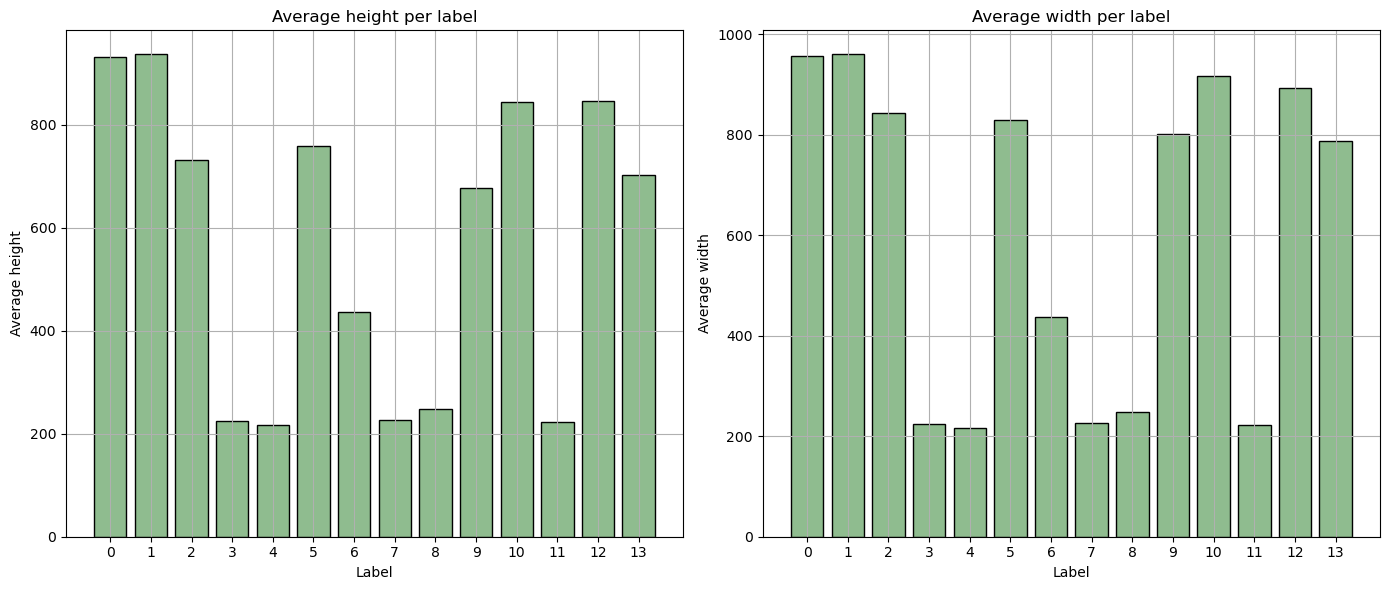

In [9]:
from matplotlib import pyplot as plt

avg_dimension_1 = {label: np.mean(dimension) for label, dimension in dimension_1.items()}
avg_dimension_2 = {label: np.mean(dimension) for label, dimension in dimension_2.items()}

dimension1_means = list(avg_dimension_1.values())
dimension2_means = list(avg_dimension_2.values())
labels = list(range(14))
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(14,6))


ax1.bar(labels, dimension1_means, color='darkseagreen', edgecolor='black')
ax1.set_title('Average height per label')
ax1.set_xlabel('Label')
ax1.set_ylabel('Average height')
ax1.set_xticks(range(14))
ax1.grid(True)

ax2.bar(labels, dimension2_means, color='darkseagreen', edgecolor='black')
ax2.set_title('Average width per label')
ax2.set_xlabel('Label')
ax2.set_ylabel('Average width')
ax2.set_xticks(range(14))
ax2.grid(True)


plt.tight_layout()


plt.show()


In [ ]:

TARGET_HEIGHT = 224
TARGET_WIDTH = 224

# Resize function in case it is needed
def resize_images(example):
    # Resize the image using PIL
    example['image'] = example['image'].resize((TARGET_WIDTH, TARGET_HEIGHT), Image.BICUBIC)
    return example

# Apply the resizing function
df_train_rs = df_train.map(resize_images)
df_validation_rs = df_validation.map(resize_images)
df_test_rs = df_test.map(resize_images)

In [14]:
import numpy as np
# computing the shape of the images
image_shape = np.array(df_train_rs[0]["image"]).shape
print(f"Shape of  image in df_train_rs: {image_shape}")

image_shape = np.array(df_validation_rs[0]["image"]).shape
print(f"Shape of  image in df_validation_rs: {image_shape}")

image_shape = np.array(df_test_rs[0]["image"]).shape
print(f"Shape of  image in df_test_rs: {image_shape}")

Shape of  image in df_train_rs: (224, 224, 3)
Shape of  image in df_validation_rs: (224, 224, 3)
Shape of  image in df_test_rs: (224, 224, 3)


In [ ]:
# Create a TensorFlow dataset
tf_train = df_train_rs.to_tf_dataset(
            columns='image',
            label_cols='label',
            batch_size=32,
            shuffle=True,
            drop_remainder=False
            )
tf_validation= df_validation_rs.to_tf_dataset(
            columns='image',
            label_cols='label',
            batch_size=32,
            shuffle=True,
            drop_remainder=False
            )
tf_test = df_test_rs.to_tf_dataset(
            columns='image',
            label_cols='label',
            batch_size=128,
            shuffle=True,
            drop_remainder=False)

In [11]:
import os
import tensorflow as tf
current_dir = os.getcwd()
save_path_train = os.path.join(current_dir, 'Train_dataset')
save_path_valid = os.path.join(current_dir, 'Valid_dataset')
save_path_test = os.path.join(current_dir, 'Test_dataset')

#tf.data.experimental.save(tf_train, save_path_train)
#tf.data.experimental.save(tf_validation, save_path_valid )
#tf.data.experimental.save(tf_test, save_path_test)

# Load the saved datasets
train_dataset_224 = tf.data.experimental.load(save_path_train)
validation_dataset_224 = tf.data.experimental.load(save_path_valid )
test_dataset_224 = tf.data.experimental.load(save_path_test)

In [12]:
import tensorflow as tf
import numpy as np

def process_dataset(dataset, target_size=(96, 96)):
    """
    Process a TensorFlow dataset into scaled images and labels suitable for ML models.
    
    Args:
        dataset: tf.data.Dataset containing image-label pairs
        target_size: tuple of (height, width) for image resizing
        
    Returns:
        processed_images: numpy array of flattened, scaled images
        labels: numpy array of labels
    """
    images_list = []
    labels_list = []
    
    # Process each image-label pair
    for image, label in dataset.unbatch():
        # Convert and resize image
        image = tf.image.resize(image, target_size)
        # Normalize to [0,1]
        image = image.numpy().astype('float32') / 255.0
        # Ensure correct shape
        if len(image.shape) == 2:
            image = np.expand_dims(image, axis=-1)
        # Flatten image
        images_list.append(image.reshape(-1))
        labels_list.append(label)
    
    # Stack and convert to numpy arrays
    processed_images = np.vstack(images_list)
    labels = np.array(labels_list)
    
    return processed_images, labels


In [22]:
# Usage example:
print("Processing train dataset...")
# draw a random sample of size 1000,100,100 from the training,val,test dataset for faster processing
train_dataset_32_numpy, train_labels_numpy = process_dataset(train_dataset_224 ,target_size=(32, 32))
print("Processing validation dataset...")
validation_dataset_32_numpy, validation_labels_numpy = process_dataset(validation_dataset_224,target_size=(32,32))
print("Processing test dataset...")
test_dataset_32_numpy, test_labels_numpy = process_dataset(test_dataset_224,target_size=(32,32))

Processing train dataset...


2025-01-30 23:03:10.025756: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Processing validation dataset...
Processing test dataset...


In [14]:
# Print dimensions
print("\nDataset Dimensions:")
print("-" * 50)
print(f"Training Data:")
print(f"Images: {train_dataset_32_numpy.shape} (samples, features)")
print(f"Labels: {train_labels_numpy.shape}")
print(f"\nValidation Data:")
print(f"Images: {validation_dataset_32_numpy.shape} (samples, features)")
print(f"Labels: {validation_labels_numpy.shape}")
print(f"\nTest Data:")
print(f"Images: {test_dataset_32_numpy.shape} (samples, features)")
print(f"Labels: {test_labels_numpy.shape}")

# Print feature information
n_features = train_dataset_32_numpy.shape[1]
print(f"\nNumber of features per image: {n_features} (32x32x3 flattened)")


Dataset Dimensions:
--------------------------------------------------
Training Data:
Images: (29322, 3072) (samples, features)
Labels: (29322,)

Validation Data:
Images: (3660, 3072) (samples, features)
Labels: (3660,)

Test Data:
Images: (3674, 3072) (samples, features)
Labels: (3674,)

Number of features per image: 3072 (32x32x3 flattened)


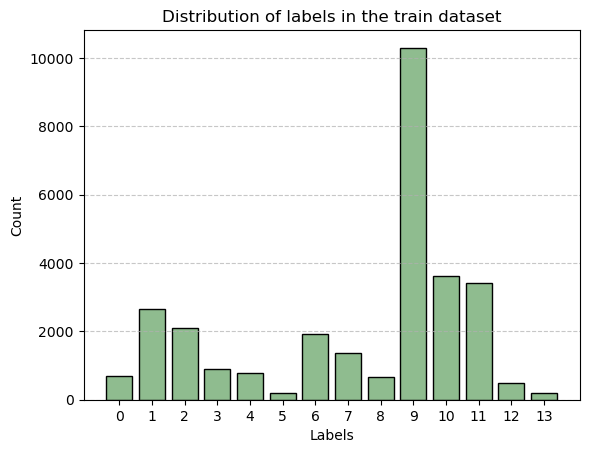

In [21]:
import numpy as np
import matplotlib.pyplot as plt


unique_labels, label_counts = np.unique(train_labels_numpy, return_counts=True)

# Create bar chart
plt.bar(unique_labels, label_counts, color='darkseagreen',edgecolor='black')

# Add grid
plt.grid(True, axis='y', linestyle='--', alpha=0.7)

plt.xticks(np.arange(0, 14, 1))
# Add labels and title
plt.xlabel('Labels')
plt.ylabel('Count')
plt.title('Distribution of labels in the train dataset')


plt.show()


Histogram Gradient Boosting 

In [ ]:
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import classification_report, accuracy_score
import pandas as pd

max_features_list = [0.1, 0.3,0.5]
max_depth_list = [3, 5, 7]
min_samples_leaf_list = [10,30,50]
results = []
x = 0
for max_feature in max_features_list:
    for max_depth in max_depth_list:
        for leaf in min_samples_leaf_list:
                    
            histgb= HistGradientBoostingClassifier(
                max_iter= 5000, 
                learning_rate = 0.1,
                max_depth= max_depth,
                early_stopping=True, 
                validation_fraction= 0.1,
                max_features = max_feature, 
                min_samples_leaf = leaf,
                class_weight = 'balanced', 
                n_iter_no_change=10 )
                    
            print('training the model...')
            histgb.fit(train_dataset_32_numpy, train_labels_numpy)
            print('making prediction..')
            y_train_hat_histgb = histgb.predict(train_dataset_32_numpy)
            train_acc_histgb = accuracy_score(train_labels_numpy, y_train_hat_histgb)
            y_val_hat_histgb = histgb.predict(validation_dataset_32_numpy)
            val_acc_histgb = accuracy_score(validation_labels_numpy, y_val_hat_histgb)
            results.append([train_acc_histgb,val_acc_histgb, histgb.n_iter_, max_feature, max_depth, leaf ])
            x +=1
            print(f"iteration {x} completed")
                    
results = pd.DataFrame(results)
results.columns = ['Train Accuracy', 'Validation Accuracy', 'max_iter', 'max_features', 'max_depth', 'min_samples_leaf']

In [ ]:
top_5_results = results.nlargest(5, 'Validation Accuracy')
print(top_5_results )

In [ ]:
X_train = np.concatenate([train_dataset_32_numpy, validation_dataset_32_numpy])
y_train = np.concatenate([train_labels_numpy, validation_labels_numpy])

histgb_best = HistGradientBoostingClassifier(
                max_iter= 80, 
                learning_rate = 0.1,
                max_depth= 5,
                early_stopping= False, 
                max_features = 0.5, 
                class_weight  = 'balanced',
                min_samples_leaf =50)

histgb_best.fit(X_train, y_train)
test_predictions = histgb_best.predict(test_dataset_32_numpy)
print(f"Accuracy: {accuracy_score(test_labels_numpy, test_predictions):.4f}")
print(classification_report(test_labels_numpy, test_predictions))


Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier


from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
import pandas as pd

n_estimators_list = [500,1000]
max_depth_list = [30,50,70] 
min_samples_leaf_list = [1,2,3]
min_samples_split_list = [2,4,6]

results_32 = []
x= 0
for n_estimators in n_estimators_list:
    for max_depth in max_depth_list:
        for min_samples_leaf in min_samples_leaf_list:
            for min_samples_split in min_samples_split_list:
                rf_32 = RandomForestClassifier(
                    n_estimators=n_estimators,
                    max_depth =max_depth,
                    min_samples_leaf=min_samples_leaf,
                    min_samples_split =min_samples_split,
                    class_weight  = 'balanced',
                    n_jobs= -1)
                rf_32.fit(train_dataset_32_numpy, train_labels_numpy)
                y_train_hat_rf_32 = rf_32.predict(train_dataset_32_numpy)
                train_acc_rf_32 = accuracy_score(train_labels_numpy, y_train_hat_rf_32)
                y_val_hat_rf_32 = rf_32.predict(validation_dataset_32_numpy)
                val_acc_rf_32 = accuracy_score(validation_labels_numpy,  y_val_hat_rf_32)
                results_32.append([train_acc_rf_32, val_acc_rf_32, n_estimators, max_depth, min_samples_leaf, min_samples_split])
                x= x+1
                print(x)
                
results_32 = pd.DataFrame(results_32)       
results_32.columns = ['Train accuracy', 'Validation accuracy ', 'n_estimators', 'max_depth', 'min_samples_leaf','min_samples_split']

In [ ]:
top_10_32 = results_32.nlargest(10,'Validation accuracy ')
print(top_10_32)

In [ ]:
from sklearn.ensemble import RandomForestClassifier


from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
import pandas as pd

n_estimators_list = [500,1000]
max_depth_list = [30,50,70] 
min_samples_leaf_list = [5,8]
min_samples_split_list = [8,10]

results_32 = []
x= 0
for n_estimators in n_estimators_list:
    for max_depth in max_depth_list:
        for min_samples_leaf in min_samples_leaf_list:
            for min_samples_split in min_samples_split_list:
                rf_32 = RandomForestClassifier(
                    n_estimators=n_estimators,
                    max_depth =max_depth,
                    min_samples_leaf=min_samples_leaf,
                    min_samples_split =min_samples_split,
                    class_weight = 'balanced',
                    n_jobs= -1)
                rf_32.fit(train_dataset_32_numpy, train_labels_numpy)
                y_train_hat_rf_32 = rf_32.predict(train_dataset_32_numpy)
                train_acc_rf_32 = accuracy_score(train_labels_numpy, y_train_hat_rf_32)
                y_val_hat_rf_32 = rf_32.predict(validation_dataset_32_numpy)
                val_acc_rf_32 = accuracy_score(validation_labels_numpy,  y_val_hat_rf_32)
                results_32.append([train_acc_rf_32, val_acc_rf_32, n_estimators, max_depth, min_samples_leaf, min_samples_split])
                x= x+1
                print(x)
                
results_32 = pd.DataFrame(results_32)       
results_32.columns = ['Train accuracy', 'Validation accuracy ', 'n_estimators', 'max_depth', 'min_samples_leaf','min_samples_split']

In [ ]:
top_10_32 = results_32.nlargest(10, 'Validation accuracy ')
print(top_10_32)

In [ ]:
best_rf= RandomForestClassifier(
                n_estimators=1000,
                max_depth = 50,
                min_samples_leaf=5,
                min_samples_split=8,
                class_weight = 'balanced',
                n_jobs= -1)

best_rf.fit(X_train, y_train)
test_predictions = best_rf.predict(test_dataset_32_numpy)
print(f"Accuracy: {accuracy_score(test_labels_numpy, test_predictions):.4f}")
print(classification_report(test_labels_numpy, test_predictions))

Voting Classifier

In [14]:
from sklearn.ensemble import VotingClassifier
voting_clf = VotingClassifier(estimators=[('rf', best_rf), ('HGB', histgb_best)], voting='soft')
voting_clf.fit(X_train, y_train)

y_train_hat_vot = voting_clf.predict(X_train)
print(f" Train Accuracy: {accuracy_score(y_train, y_train_hat_vot):.4f}")

y_test_hat_vot = voting_clf.predict(test_dataset_32_numpy)
print(f" Test Accuracy: {accuracy_score(test_labels_numpy, y_test_hat_vot):.4f}")
print(classification_report(test_labels_numpy, y_test_hat_vot))

python(52293) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


 Train Accuracy: 0.9206
 Test Accuracy: 0.6516
              precision    recall  f1-score   support

           0       0.28      0.30      0.29        88
           1       0.43      0.65      0.52       333
           2       0.30      0.31      0.30       263
           3       0.73      0.65      0.69       113
           4       0.85      0.73      0.78        99
           5       0.11      0.04      0.06        25
           6       0.84      0.80      0.82       242
           7       0.80      0.80      0.80       171
           8       0.75      0.61      0.68        83
           9       0.80      0.74      0.77      1288
          10       0.52      0.43      0.47       453
          11       0.72      0.88      0.79       426
          12       0.32      0.20      0.25        64
          13       0.67      0.31      0.42        26

    accuracy                           0.65      3674
   macro avg       0.58      0.53      0.55      3674
weighted avg       0.66      0.65

Testing with image size 64x64

In [45]:
from sklearn.metrics import classification_report, accuracy_score

train_dataset_64_numpy, train_labels_numpy_64 = process_dataset(train_dataset_224 ,target_size=(64, 64))
print("Processing validation dataset...")
validation_dataset_64_numpy, validation_labels_numpy_64 = process_dataset(validation_dataset_224,target_size=(64,64))
print("Processing test dataset...")
test_dataset_64_numpy, test_labels_numpy_64= process_dataset(test_dataset_224,target_size=(64,64))


Processing validation dataset...


2025-01-29 17:22:24.539856: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Processing test dataset...


In [46]:
# Print dimensions
print("\nDataset Dimensions:")
print("-" * 50)
print(f"Training Data:")
print(f"Images: {train_dataset_64_numpy.shape} (samples, features)")
print(f"Labels: {train_labels_numpy_64.shape}")
print(f"\nValidation Data:")
print(f"Images: {validation_dataset_64_numpy.shape} (samples, features)")
print(f"Labels: {validation_labels_numpy_64.shape}")
print(f"\nTest Data:")
print(f"Images: {test_dataset_64_numpy.shape} (samples, features)")
print(f"Labels: {test_labels_numpy_64.shape}")

# Print feature information
n_features = train_dataset_64_numpy.shape[1]
print(f"\nNumber of features per image: {n_features} (64x64x3 flattened)")


Dataset Dimensions:
--------------------------------------------------
Training Data:
Images: (29322, 12288) (samples, features)
Labels: (29322,)

Validation Data:
Images: (3660, 12288) (samples, features)
Labels: (3660,)

Test Data:
Images: (3674, 12288) (samples, features)
Labels: (3674,)

Number of features per image: 12288 (64x64x3 flattened)


In [32]:
X_train = np.concatenate([train_dataset_64_numpy, validation_dataset_64_numpy])
y_train = np.concatenate([train_labels_numpy_64, validation_labels_numpy_64])

histgb_best.fit(X_train, y_train)
test_predictions = histgb_best.predict(test_dataset_64_numpy)
print(f"Accuracy: {accuracy_score(test_labels_numpy_64, test_predictions):.4f}")
print(classification_report(test_labels_numpy_64, test_predictions))

Accuracy: 0.6206
              precision    recall  f1-score   support

           0       0.21      0.30      0.24        88
           1       0.42      0.59      0.49       333
           2       0.24      0.31      0.27       263
           3       0.69      0.65      0.67       113
           4       0.81      0.78      0.79        99
           5       0.00      0.00      0.00        25
           6       0.82      0.77      0.79       242
           7       0.77      0.79      0.78       171
           8       0.79      0.70      0.74        83
           9       0.82      0.68      0.74      1288
          10       0.44      0.40      0.42       453
          11       0.74      0.86      0.79       426
          12       0.24      0.20      0.22        64
          13       0.55      0.23      0.32        26

    accuracy                           0.62      3674
   macro avg       0.54      0.52      0.52      3674
weighted avg       0.65      0.62      0.63      3674



In [14]:
best_rf.fit(X_train, y_train)
test_predictions = best_rf.predict(test_dataset_64_numpy)
print(f"Accuracy: {accuracy_score(test_labels_numpy_64, test_predictions):.4f}")
print(classification_report(test_labels_numpy_64, test_predictions))

Accuracy: 0.6606
              precision    recall  f1-score   support

           0       0.45      0.20      0.28        88
           1       0.41      0.69      0.51       333
           2       0.38      0.24      0.29       263
           3       0.91      0.65      0.76       113
           4       0.90      0.70      0.78        99
           5       0.25      0.04      0.07        25
           6       0.79      0.80      0.79       242
           7       0.86      0.78      0.82       171
           8       0.77      0.69      0.73        83
           9       0.73      0.81      0.77      1288
          10       0.55      0.33      0.41       453
          11       0.68      0.90      0.77       426
          12       0.73      0.12      0.21        64
          13       1.00      0.15      0.27        26

    accuracy                           0.66      3674
   macro avg       0.67      0.51      0.53      3674
weighted avg       0.66      0.66      0.64      3674



In [48]:
voting_clf = VotingClassifier(estimators=[('rf', best_rf), ('HGB', histgb_best)], voting='soft')
voting_clf.fit(X_train, y_train)

y_train_hat_vot = voting_clf.predict(X_train)
print(f" Train Accuracy: {accuracy_score(y_train, y_train_hat_vot):.4f}")

y_test_hat_vot = voting_clf.predict(test_dataset_64_numpy)
print(f" Test Accuracy: {accuracy_score(test_labels_numpy_64, y_test_hat_vot):.4f}")
print(classification_report(test_labels_numpy_64, y_test_hat_vot))

 Train Accuracy: 0.9333
 Test Accuracy: 0.6625
              precision    recall  f1-score   support

           0       0.26      0.22      0.23        88
           1       0.45      0.71      0.55       333
           2       0.30      0.33      0.31       263
           3       0.82      0.66      0.74       113
           4       0.84      0.74      0.78        99
           5       0.20      0.04      0.07        25
           6       0.84      0.79      0.81       242
           7       0.82      0.80      0.81       171
           8       0.81      0.66      0.73        83
           9       0.80      0.75      0.77      1288
          10       0.53      0.43      0.48       453
          11       0.73      0.90      0.81       426
          12       0.36      0.16      0.22        64
          13       0.64      0.27      0.38        26

    accuracy                           0.66      3674
   macro avg       0.60      0.53      0.55      3674
weighted avg       0.67      0.66

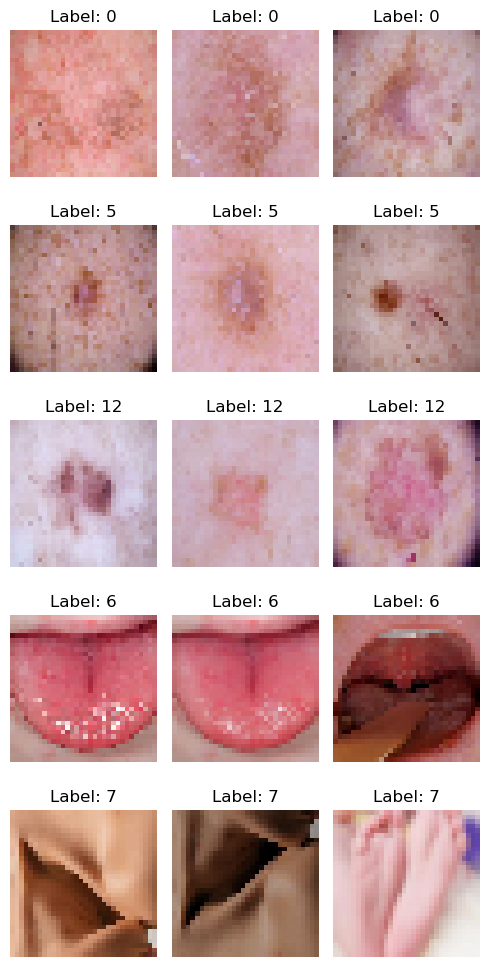

In [23]:
import matplotlib.pyplot as plt
import numpy as np


desired_labels = [0, 5,12,6,7]
images_per_label = 3


collected_images = {label: [] for label in desired_labels}

for i in range(len(test_dataset_32_numpy)):
    image = test_dataset_32_numpy[i]
    label = test_labels_numpy[i]

    if label in desired_labels and len(collected_images[label]) < images_per_label:
        image = image.reshape(32, 32, 3)  
        collected_images[label].append(image)

    if all(len(images) == images_per_label for images in collected_images.values()):
        break


fig, axes = plt.subplots(len(desired_labels), images_per_label, figsize=(5, 10))

for row, label in enumerate(desired_labels):
    for col in range(images_per_label):
        axes[row, col].imshow(collected_images[label][col])
        axes[row, col].set_title(f"Label: {label}")
        axes[row, col].axis("off")

plt.tight_layout()
plt.show()

